# Emulating WOFOST Leaf Dynamics with a Neural Network

This notebook demonstrates how to replace a physical module (Leaf Dynamics) in `diffwofost` with a neural network surrogate.
We will:
1. Run the physical `WOFOST_Leaf_Dynamics` model to generate reference data.
2. Prepare input features (Weather, DVS, Biomass inputs) and target outputs (LAI, TWLV).
3. Train a simple PyTorch LSTM to mimic the behavior of the physical model.
4. Compare the emulator's performance against the physical model.

In [1]:
# 1. Setup and Imports
import sys
import copy
import urllib.request
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import warnings

# Install diffwofost if not already installed (uncomment if needed)
# !pip install diffwofost

from diffwofost.physical_models.config import Configuration, ComputeConfig
from diffwofost.physical_models.crop.leaf_dynamics import WOFOST_Leaf_Dynamics
from diffwofost.physical_models.utils import EngineTestHelper, prepare_engine_input, get_test_data

# Use CPU
ComputeConfig.set_device('cpu')
warnings.filterwarnings("ignore", message="To copy construct from a tensor.*")

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

In [2]:
# 2. Data Preparation and Reference Simulation

# Download test data
url = "https://raw.githubusercontent.com/ajwdewit/pcse/refs/heads/master/tests/test_data/test_leafdynamics_wofost72_01.yaml"
filename = "test_leafdynamics_wofost72_01.yaml"
if not Path(filename).exists():
    urllib.request.urlretrieve(url, filename)
    print(f"Downloaded: {filename}")

# Load and prepare inputs
test_data = get_test_data(filename)
crop_model_params_provider, weather_data_provider, agro_management_inputs, external_states = (
    prepare_engine_input(test_data, ["SPAN", "TDWI", "TBASE", "PERDL", "RGRLAI"])
)

# Configure the physical model
leaf_dynamics_config = Configuration(
    CROP=WOFOST_Leaf_Dynamics,
    OUTPUT_VARS=["LAI", "TWLV"],
)

# Define a wrapper to run the physical model
class PhysicalModelWrapper(nn.Module):
    def __init__(self, params, weather, agro, config, ext_states):
        super().__init__()
        self.params = params
        self.weather = weather
        self.agro = agro
        self.config = config
        self.ext_states = ext_states
        
    def forward(self):
        # Deep copy inputs to prevent in-place modification issues across runs
        params_ = copy.deepcopy(self.params)
        states_ = copy.deepcopy(self.ext_states)
        
        # Run engine
        engine = EngineTestHelper(
            params_, self.weather, self.agro, self.config, states_
        )
        engine.run_till_terminate()
        return engine.get_output()

# Generate Reference Data
print("Running physical model...")
physical_model = PhysicalModelWrapper(
    crop_model_params_provider, weather_data_provider, agro_management_inputs,
    leaf_dynamics_config, external_states
)
reference_results = physical_model()

# Extract LAI and TWLV from results
ref_lai = torch.tensor([x["LAI"] for x in reference_results], dtype=torch.float32)
ref_twlv = torch.tensor([x["TWLV"] for x in reference_results], dtype=torch.float32)

# Stack target variables: Shape [Sequence_Length, 2]
Y_target = torch.stack([ref_lai, ref_twlv], dim=1).unsqueeze(0) # Batch size 1
print(f"Reference data generated. Target shape: {Y_target.shape}")

Running physical model...
Reference data generated. Target shape: torch.Size([1, 260, 2])


In [3]:
# 3. Prepare Training Data for Neural Network
import datetime

# We need to construct the input tensor X [Batch, Time, Features]
# Features: DVS, FL, ADMI, RFTRA, SAI, PAI, TEMP

# Get the simulation days
num_steps = len(reference_results)

# Extract external states
# external_states is a list of dictionaries, one per timestep
# We iterate over the list to extract the time series for each variable by key
dvs = torch.stack([item["DVS"] for item in external_states]).float()
fl = torch.stack([item["FL"] for item in external_states]).float()
admi = torch.stack([item["ADMI"] for item in external_states]).float()
rftra = torch.stack([item["RFTRA"] for item in external_states]).float()
sai = torch.stack([item["SAI"] for item in external_states]).float()
pai = torch.stack([item["PAI"] for item in external_states]).float()

# Extract Weather Data (TEMP)
# We can use the 'DAY' key from each external state to query the weather provider
temps = []
for item in external_states:
    day = item["DAY"]
    meteo = weather_data_provider(day)
    temps.append(meteo.TEMP)

temp_tensor = torch.tensor(temps, dtype=torch.float32)

# Stack features
# Shape: [Time, Features]
feature_list = [dvs, fl, admi, rftra, sai, pai, temp_tensor]
X_train = torch.stack(feature_list, dim=1).unsqueeze(0) # [1, Time, 7]

print(f"Input features shape: {X_train.shape}")
print(f"Target shape: {Y_target.shape}")
print("Features: DVS, FL, ADMI, RFTRA, SAI, PAI, TEMP")

Input features shape: torch.Size([1, 260, 7])
Target shape: torch.Size([1, 260, 2])
Features: DVS, FL, ADMI, RFTRA, SAI, PAI, TEMP


In [4]:
# 4. Define the Neural Network Module (Surrogate)

class LeafEmulator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
        # Optional: Initialize weights
        nn.init.xavier_uniform_(self.fc.weight)

    def forward(self, x):
        # x shape: [Batch, Time, Input_Size]
        lstm_out, _ = self.lstm(x)
        output = self.fc(lstm_out)
        return output

# Hyperparameters
input_size = 7
hidden_size = 64
output_size = 2 # LAI, TWLV

# Instantiate the model
model = LeafEmulator(input_size, hidden_size, output_size)
print(model)

LeafEmulator(
  (lstm): LSTM(7, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=2, bias=True)
)


Starting training...
Epoch 0, Loss: 1.458910
Epoch 50, Loss: 0.607179
Epoch 100, Loss: 0.594549
Epoch 150, Loss: 0.566786
Epoch 200, Loss: 0.518069
Epoch 250, Loss: 0.470885
Epoch 300, Loss: 0.427662
Epoch 350, Loss: 0.393489
Epoch 400, Loss: 0.366955
Epoch 450, Loss: 0.343366
Epoch 500, Loss: 0.321046
Epoch 550, Loss: 0.299312
Epoch 600, Loss: 0.280198
Epoch 650, Loss: 0.262632
Epoch 700, Loss: 0.246340
Epoch 750, Loss: 0.232399
Epoch 800, Loss: 0.216142
Epoch 850, Loss: 0.202486
Epoch 900, Loss: 0.189662
Epoch 950, Loss: 0.177599
Epoch 1000, Loss: 0.166241
Epoch 1050, Loss: 0.155542
Epoch 1100, Loss: 0.145468
Epoch 1150, Loss: 0.135965
Epoch 1200, Loss: 0.127013
Epoch 1250, Loss: 0.118587
Epoch 1300, Loss: 0.110649
Epoch 1350, Loss: 0.103246
Epoch 1400, Loss: 0.099699
Epoch 1450, Loss: 0.088105
Epoch 1500, Loss: 0.080889
Epoch 1550, Loss: 0.074873
Epoch 1600, Loss: 0.069578
Epoch 1650, Loss: 0.064088
Epoch 1700, Loss: 0.059347
Epoch 1750, Loss: 0.055067
Epoch 1800, Loss: 0.050812
Epo

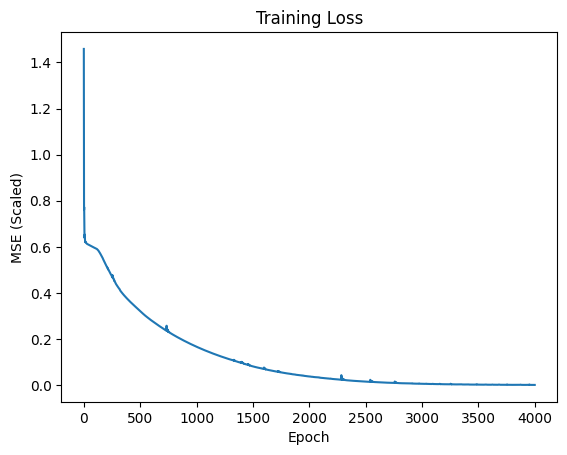

In [5]:
# 5. Train the Neural Network

# Optimizer and Loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.MSELoss()

# Training params
epochs = 4000
loss_history = []

print("Starting training...")
for epoch in range(epochs):
    optimizer.zero_grad()
    
    # Forward pass
    predictions = model(X_train)
    
    # Compute loss
    # Normalize? 
    # LAI is roughly 0-5, TWLV 0-5000. Large difference in scale.
    # We should probably normalize targets or use a weighted loss.
    # Simple workaround: Divide TWLV by 1000 in loss calculation or normalize data.
    # Let's normalize the targets for the loss calculation.
    
    scale = torch.tensor([1.0, 1000.0]) # LAI scale ~1, TWLV scale ~1000
    loss = loss_fn(predictions / scale, Y_target / scale)
    
    # Backward
    loss.backward()
    optimizer.step()
    
    loss_history.append(loss.item())
    
    if epoch % 50 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.6f}")

print("Training complete.")

# Plot loss
plt.figure()
plt.plot(loss_history)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE (Scaled)")
plt.show()

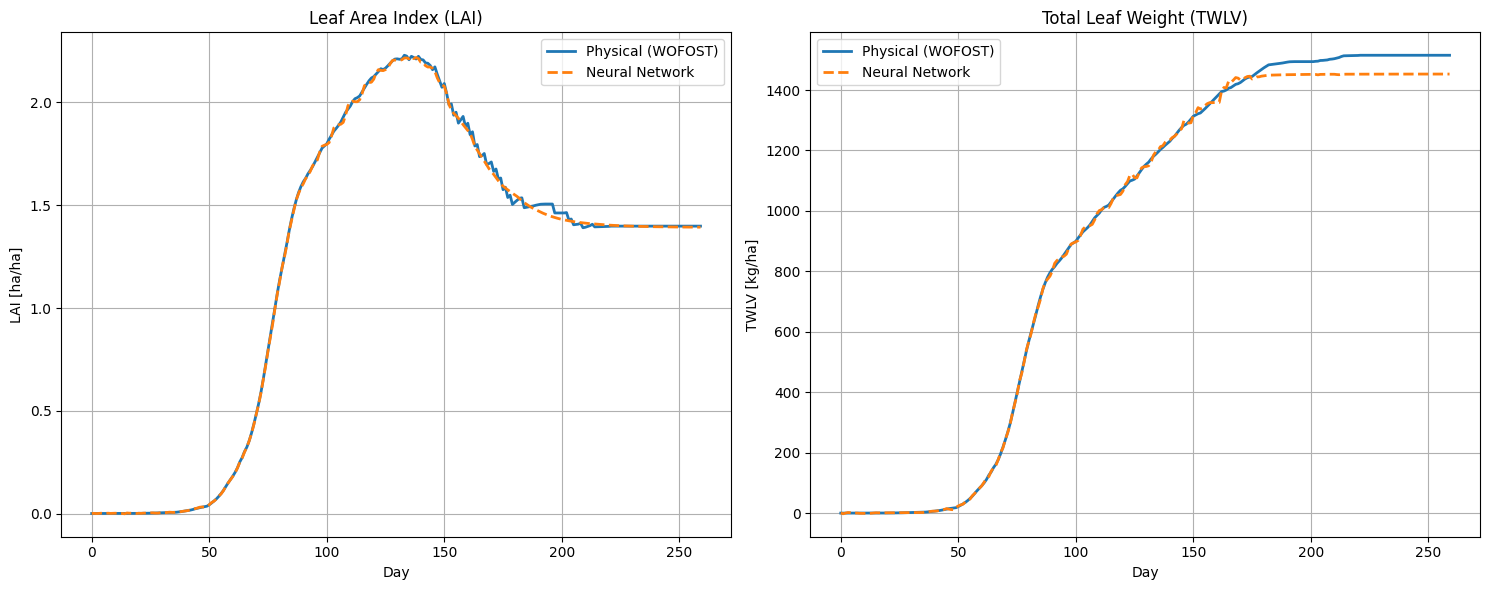

MAE LAI: 0.0090
MAE TWLV: 20.0481
The Neural Network has learned to emulate the physical Leaf Dynamics dynamics!


In [6]:
# 6. Compare Physical vs. Neural Model Results

# Run inference
model.eval()
with torch.no_grad():
    predictions = model(X_train)

# Flatten for plotting
days = np.arange(num_steps)

lai_pred = predictions[0, :, 0].numpy()
twlv_pred = predictions[0, :, 1].numpy()

lai_true = Y_target[0, :, 0].numpy()
twlv_true = Y_target[0, :, 1].numpy()

# Plot
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# LAI
axes[0].plot(days, lai_true, label="Physical (WOFOST)", linewidth=2)
axes[0].plot(days, lai_pred, label="Neural Network", linestyle="--", linewidth=2)
axes[0].set_title("Leaf Area Index (LAI)")
axes[0].set_xlabel("Day")
axes[0].set_ylabel("LAI [ha/ha]")
axes[0].legend()
axes[0].grid(True)

# TWLV
axes[1].plot(days, twlv_true, label="Physical (WOFOST)", linewidth=2)
axes[1].plot(days, twlv_pred, label="Neural Network", linestyle="--", linewidth=2)
axes[1].set_title("Total Leaf Weight (TWLV)")
axes[1].set_xlabel("Day")
axes[1].set_ylabel("TWLV [kg/ha]")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

# Calculate Error Metrics
mae_lai = np.mean(np.abs(lai_true - lai_pred))
mae_twlv = np.mean(np.abs(twlv_true - twlv_pred))
print(f"MAE LAI: {mae_lai:.4f}")
print(f"MAE TWLV: {mae_twlv:.4f}")
print("The Neural Network has learned to emulate the physical Leaf Dynamics dynamics!")

Running simulation with Neural Network surrogate...
Simulation complete.


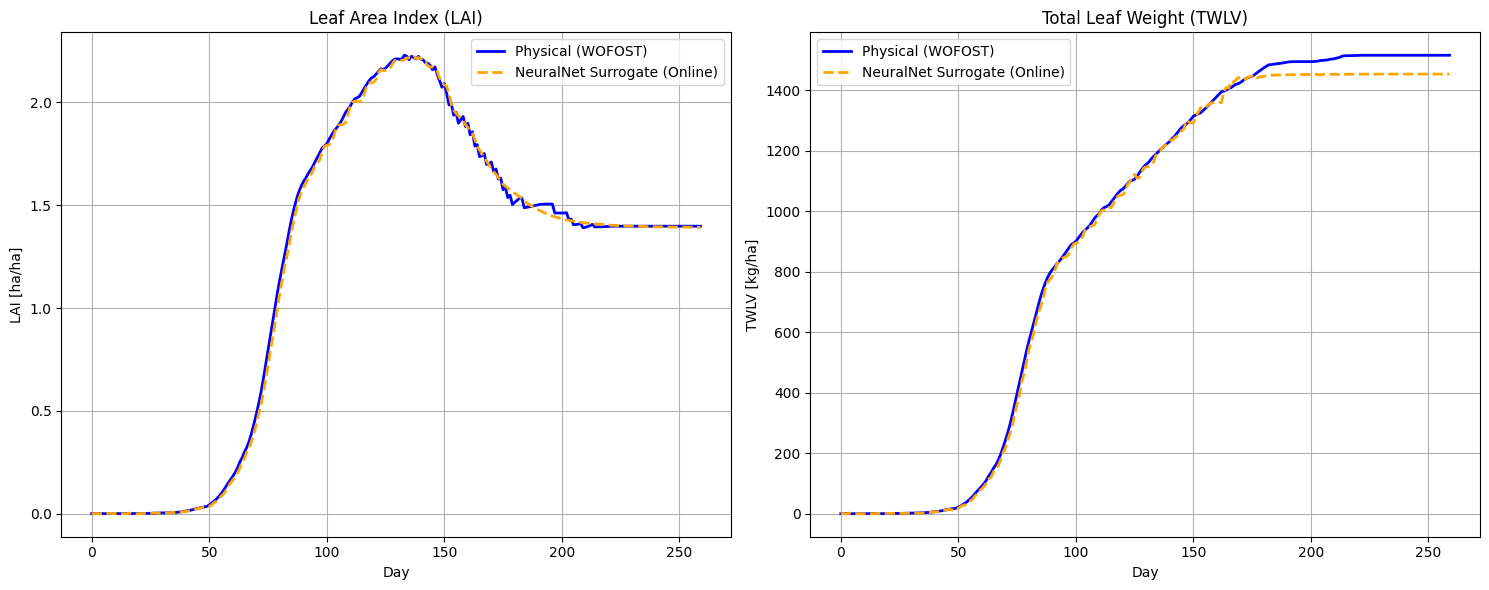

In [7]:
# 7. Use the Neural Network in the Simulation Engine

from pcse.base import SimulationObject, StatesTemplate, RatesTemplate, ParamTemplate
from pcse.traitlets import Any
from diffwofost.physical_models.config import ComputeConfig
import torch
import numpy as np

class WOFOST_Leaf_Dynamics_NeuralNet(SimulationObject):
    """
    Surrogate model for Leaf Dynamics using a trained LSTM.
    """
    model = None  # Class variable to hold the trained PyTorch model
    
    class Parameters(ParamTemplate):
        """Dummy parameters to satisfy the interface."""
        pass

    class StateVariables(StatesTemplate):
        LAI = Any()
        TWLV = Any()
        WLV = Any() # Published for compatibility, though simply driven by TWLV here

    class RateVariables(RatesTemplate):
        """Dummy rates."""
        pass
    
    def initialize(self, day, kiosk, parvalues):
        self.kiosk = kiosk
        
        # Define states with initial values provided as kwargs
        initial_lai = torch.tensor(0.0)
        initial_twlv = torch.tensor(0.0)
        initial_wlv = torch.tensor(0.0)

        self.states = self.StateVariables(kiosk, 
            publish=["LAI", "TWLV", "WLV"],
            LAI=initial_lai,
            TWLV=initial_twlv,
            WLV=initial_wlv
        )
        
        self.rates = self.RateVariables(kiosk)
        
        # Initialize LSTM state (hidden, cell)
        if self.model is None:
            raise ValueError("Model not set! Set WOFOST_Leaf_Dynamics_NeuralNet.model before running.")
            
        # Use private attributes (starting with _) to store internal objects
        # as SimulationObject prevents setting arbitrary public attributes.
        self._lstm_cell = self.model.lstm
        self._fc_layer = self.model.fc
        
        self._hidden_state = None 
        
        # Buffer for next state to apply in integrate()
        self._next_lai = torch.tensor(0.0)
        self._next_twlv = torch.tensor(0.0)

    def calc_rates(self, day, drv):
        # Prepare Input Feature Vector
        
        def get_val(key):
            val = self.kiosk[key]
            if isinstance(val, torch.Tensor):
                return val.item()
            return float(val)

        dvs = get_val("DVS")
        fl = get_val("FL")
        admi = get_val("ADMI")
        rftra = get_val("RFTRA")
        sai = get_val("SAI")
        pai = get_val("PAI")
        
        # Handle TEMP
        if hasattr(drv, 'TEMP'):
             temp = drv.TEMP
             if isinstance(temp, torch.Tensor):
                 temp = temp.item()
        elif hasattr(drv, 'get'):
             temp = drv.get('TEMP', 15.0) 
        else:
             temp = 15.0
            
        features = torch.tensor([[
            [dvs, fl, admi, rftra, sai, pai, temp]
        ]], dtype=torch.float32)
        
        # Run one step of the LSTM
        with torch.no_grad():
            lstm_out, self._hidden_state = self._lstm_cell(features, self._hidden_state)
            prediction = self._fc_layer(lstm_out)
        
        # Extract results
        self._next_lai = prediction[0, 0, 0]
        self._next_twlv = prediction[0, 0, 1]
        
        if self._next_lai < 0: self._next_lai = torch.tensor(0.0)
        if self._next_twlv < 0: self._next_twlv = torch.tensor(0.0)

    def integrate(self, day, delt=1.0):
        self.states.LAI = self._next_lai
        self.states.TWLV = self._next_twlv
        self.states.WLV = self._next_twlv

# -----------------
# Run the Simulation with the Neural Network
# -----------------

# Set the trained model into the class
WOFOST_Leaf_Dynamics_NeuralNet.model = model

# Configure to use the Surrogate
nn_config = Configuration(
    CROP=WOFOST_Leaf_Dynamics_NeuralNet,
    OUTPUT_VARS=["LAI", "TWLV"],
)

print("Running simulation with Neural Network surrogate...")
try:
    nn_wrapper = PhysicalModelWrapper(
        crop_model_params_provider, weather_data_provider, agro_management_inputs,
        nn_config, external_states
    )
    nn_results = nn_wrapper()
    print("Simulation complete.")

    # Extract results
    nn_sim_lai = [x["LAI"] for x in nn_results]
    nn_sim_twlv = [x["TWLV"] for x in nn_results]
    days = np.arange(len(nn_results))

    # -----------------
    # Plot Comparison (Full Simulation)
    # -----------------
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # LAI
    axes[0].plot(days, ref_lai.numpy(), label="Physical (WOFOST)", linewidth=2, color="blue")
    axes[0].plot(days, nn_sim_lai, label="NeuralNet Surrogate (Online)", linestyle="--", linewidth=2, color="orange")
    axes[0].set_title("Leaf Area Index (LAI)")
    axes[0].set_xlabel("Day")
    axes[0].set_ylabel("LAI [ha/ha]")
    axes[0].legend()
    axes[0].grid(True)

    # TWLV
    axes[1].plot(days, ref_twlv.numpy(), label="Physical (WOFOST)", linewidth=2, color="blue")
    axes[1].plot(days, nn_sim_twlv, label="NeuralNet Surrogate (Online)", linestyle="--", linewidth=2, color="orange")
    axes[1].set_title("Total Leaf Weight (TWLV)")
    axes[1].set_xlabel("Day")
    axes[1].set_ylabel("TWLV [kg/ha]")
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

except Exception as e:
    import traceback
    traceback.print_exc()


In [ ]:
# 8. End-to-End Training (Differentiable Simulation)

# We can also train the surrogate model "end-to-end" by running the full simulation,
# comparing the final outputs (e.g., LAI curves) to observations, and backpropagating
# usage the gradients through the simulation engine itself. 
# This leverages the differentiable nature of diffWOFOST.

# 1. Initialize a new, untrained model
model_e2e = LeafEmulator(input_size, hidden_size, output_size)
WOFOST_Leaf_Dynamics_NeuralNet.model = model_e2e # Point the surrogate class to this new model

# 2. Optimizer
optimizer_e2e = torch.optim.Adam(model_e2e.parameters(), lr=0.05)
loss_fn = nn.MSELoss()

print("Initialized new untrained model for end-to-end training.")

In [ ]:
# 9. Run End-to-End Training Loop

epochs_e2e = 50 
loss_history_e2e = []

print("Starting End-to-End Training (this may take a moment)...")

# We need to ensure that the engine run is clean each time
# The wrapper we defined earlier (PhysicalModelWrapper) handles re-instantiation.

for epoch in range(epochs_e2e):
    optimizer_e2e.zero_grad()
    
    # 1. Run the simulation
    # This executes the loop: [Params/Weather] -> [NeuralNet Surrogate] -> [Crop Growth] -> [Output]
    nn_results = nn_wrapper()
    
    # 2. Extract differentiable outputs
    # Engine output is a list of dicts. We extract values and stack them.
    # We must ensure we don't break the graph (e.g. by using .item() or .numpy()).
    # The 'LAI' and 'TWLV' in nn_results are Tensors because our Surrogate publishes Tensors.
    
    sim_lai = torch.stack([x["LAI"] for x in nn_results])
    sim_twlv = torch.stack([x["TWLV"] for x in nn_results])
    
    # Pack into (Batch=1, Time, Features=2) to match reference target shape
    sim_output = torch.stack([sim_lai, sim_twlv], dim=1).unsqueeze(0)
    
    # 3. Compute Loss
    # Compare full time series against the reference data (Y_target)
    # Using the same scaling as before
    scale = torch.tensor([1.0, 1000.0])
    loss = loss_fn(sim_output / scale, Y_target / scale)
    
    # 4. Backpropagate through the engine!
    loss.backward()
    
    # 5. Update weights
    optimizer_e2e.step()
    
    loss_history_e2e.append(loss.item())
    
    if epoch % 5 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.6f}")

print("End-to-End Training complete.")

plt.figure()
plt.plot(loss_history_e2e)
plt.title("End-to-End Training Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE (Scaled)")
plt.show()

In [ ]:
# 10. Validate End-to-End Trained Model

# Run inference with the fine-tuned model
# (No gradient needed for plotting)
with torch.no_grad():
    final_results = nn_wrapper()
    
final_lai = [x["LAI"] for x in final_results]
final_twlv = [x["TWLV"] for x in final_results]
days = np.arange(len(final_results))

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# LAI
axes[0].plot(days, ref_lai.numpy(), label="Reference (Physical)", linewidth=2, color="blue")
axes[0].plot(days, final_lai, label="E2E Trained NeuralNet", linestyle="--", linewidth=2, color="green")
axes[0].set_title("Leaf Area Index (LAI)")
axes[0].set_xlabel("Day")
axes[0].set_ylabel("LAI [ha/ha]")
axes[0].legend()
axes[0].grid(True)

# TWLV
axes[1].plot(days, ref_twlv.numpy(), label="Reference (Physical)", linewidth=2, color="blue")
axes[1].plot(days, final_twlv, label="E2E Trained NeuralNet", linestyle="--", linewidth=2, color="green")
axes[1].set_title("Total Leaf Weight (TWLV)")
axes[1].set_xlabel("Day")
axes[1].set_ylabel("TWLV [kg/ha]")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()